# CommLab Final Project: AQS Implemetation

## Import packages

In [49]:
from qiskit import *
import math
import random
import numpy as np
from qiskit.tools.visualization import circuit_drawer

## Initializing phase

In [50]:
def bin_to_int_key(bin_key):
    # transform binary key shared by alice and trent into KAT(integer based key)
    n = len(bin_key)
    int_key = []
    zero = []
    one = []
    for i in range(0,n):
        if not bin_key[i]:
            zero.append(i)
        else:
            one.append(i)
    int_key = zero + one
    return int_key

def generate_message(n):
    message = QuantumRegister(n, name="p")
    message_measure = ClassicalRegister(n, name="p_c")
    qc = QuantumCircuit(message, message_measure)
    for i in range(n):
        random_state = quantum_info.random_statevector(dims=2, seed=None)
        qc.initialize(random_state, message[i])
    return qc

# will be replaced with QKD
def get_shared_key(n):
    # n = len(P)
    r_AT = np.random.randint(0, 2, n)
    r_BT = np.random.randint(0, 2, 2*n + 1)

    K_AT = bin_to_int_key(r_AT)
    K_BT = bin_to_int_key(r_BT)
    
    return K_AT, K_BT, r_BT

def create_bell_states(n):
    A_pos = QuantumRegister(n)
    B_pos = QuantumRegister(n)
    #A_measure = ClassicalRegister(n)
    #B_measure = ClassicalRegister(n)    
    qc = QuantumCircuit(A_pos, B_pos)
    
    for i in range(n):
        qc.h(A_pos[i])
        qc.cnot(A_pos[i], B_pos[i])
    
    return qc.to_instruction(label="bell_state")

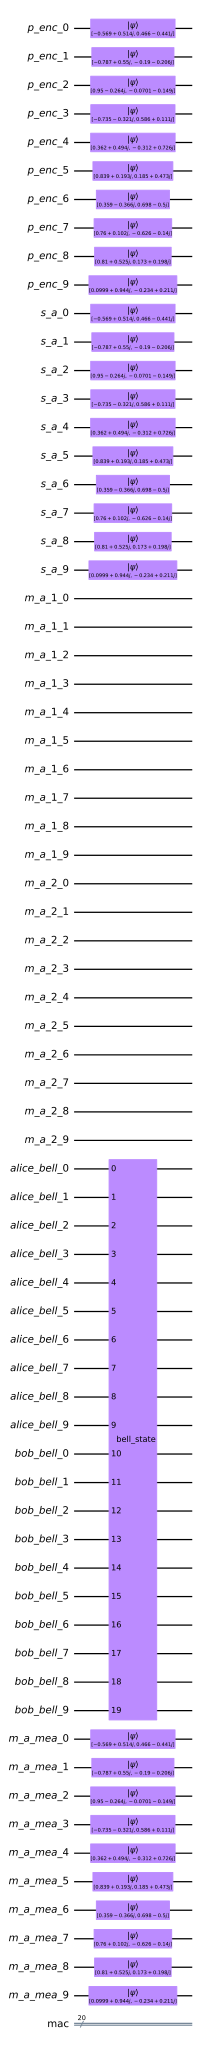

In [51]:
n = 10

P_enc = QuantumRegister(n, name="p_enc")
S_A = QuantumRegister(n, name="s_a")
M_A_1 = QuantumRegister(n, name="m_a_1")
M_A_2 = QuantumRegister(n, name="m_a_2")
A_bell = QuantumRegister(n, name="alice_bell")
B_bell = QuantumRegister(n, name="bob_bell")
for_M_A = QuantumRegister(n, name="m_a_mea")

get_M_A = ClassicalRegister(2*n, name="mac")

qc = QuantumCircuit(P_enc, S_A, M_A_1, M_A_2, A_bell, B_bell, for_M_A, get_M_A)

# Step 1
for i in range(n):
    random_state = quantum_info.random_statevector(dims=2, seed=None)
    qc.initialize(random_state, P_enc[i])
    qc.initialize(random_state, S_A[i])
    qc.initialize(random_state, for_M_A[i])

# keys generation
K_AT, K_BT, r_BT = get_shared_key(n)

#Step 2
AB_bell = []
for i in range(n):
    AB_bell.append(A_bell[i])
for i in range(n):
    AB_bell.append(B_bell[i])
qc.append(create_bell_states(n), AB_bell)
qc.draw()

## Signing phase

In [52]:
def chained_cnot_enc(n, KAT):
    # n = len(P)
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)
    for i in range(0,n):
        if i != KAT[i]:
            qc.cnot(i, KAT[i])
    return qc.to_instruction(label="chained_cnot_enc")

def bell_measurement(n):
    q1 = QuantumRegister(n)
    q2 = QuantumRegister(n)
    c = ClassicalRegister(2 * n)
    qc = QuantumCircuit(q1, q2)
    
    for i in range(n):
        qc.cnot(q2[i], q1[i])
        qc.h(q1[i])
        
    return qc.to_instruction(label="bell_measurement")

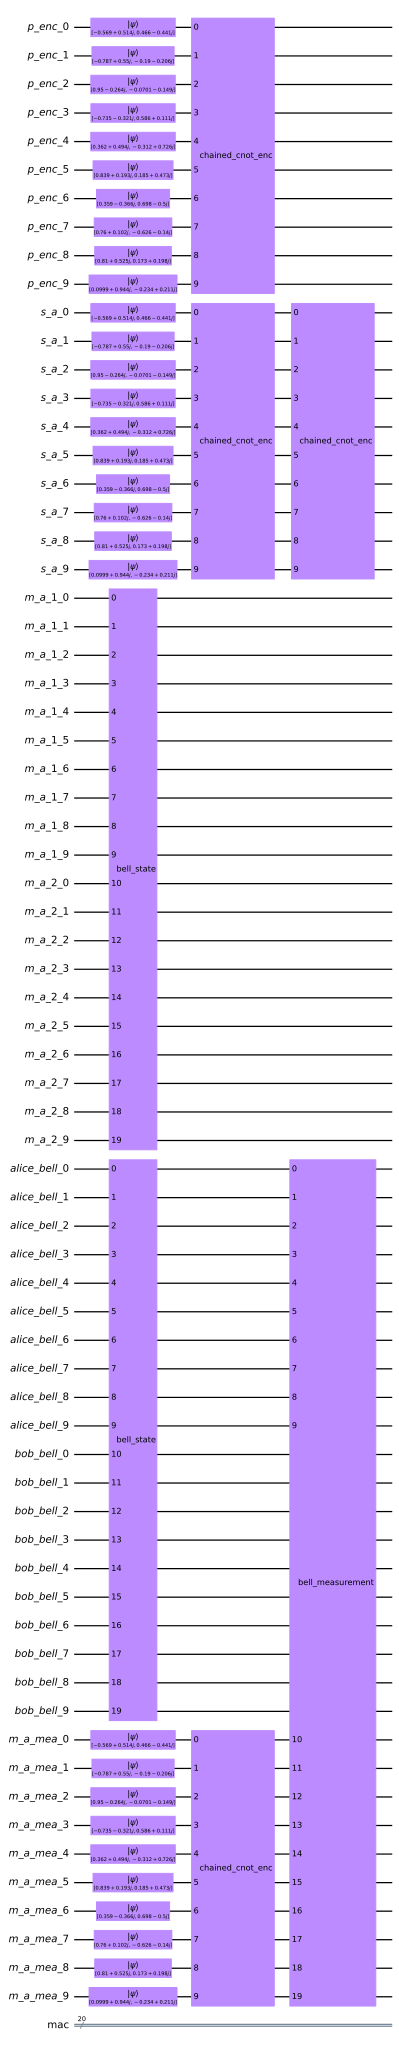

In [53]:
# Step 1
r_R = np.random.randint(0, 2, n)
K_R = bin_to_int_key(r_R)

qc.append(chained_cnot_enc(n, K_R), P_enc)

# Step 2
qc.append(chained_cnot_enc(n, K_R), S_A)
qc.append(chained_cnot_enc(n, K_AT), S_A)

# Step 3

bell_m = []

for i in range(n):
    bell_m.append(M_A_1[i])
for i in range(n):
    bell_m.append(M_A_2[i])
    
qc.append(chained_cnot_enc(n, K_R), for_M_A)
qc.append(create_bell_states(n), bell_m)

bell_m = []

for i in range(n):
    bell_m.append(A_bell[i])
for i in range(n):
    bell_m.append(for_M_A[i])
    
qc.append(bell_measurement(n), bell_m)

qc.draw()

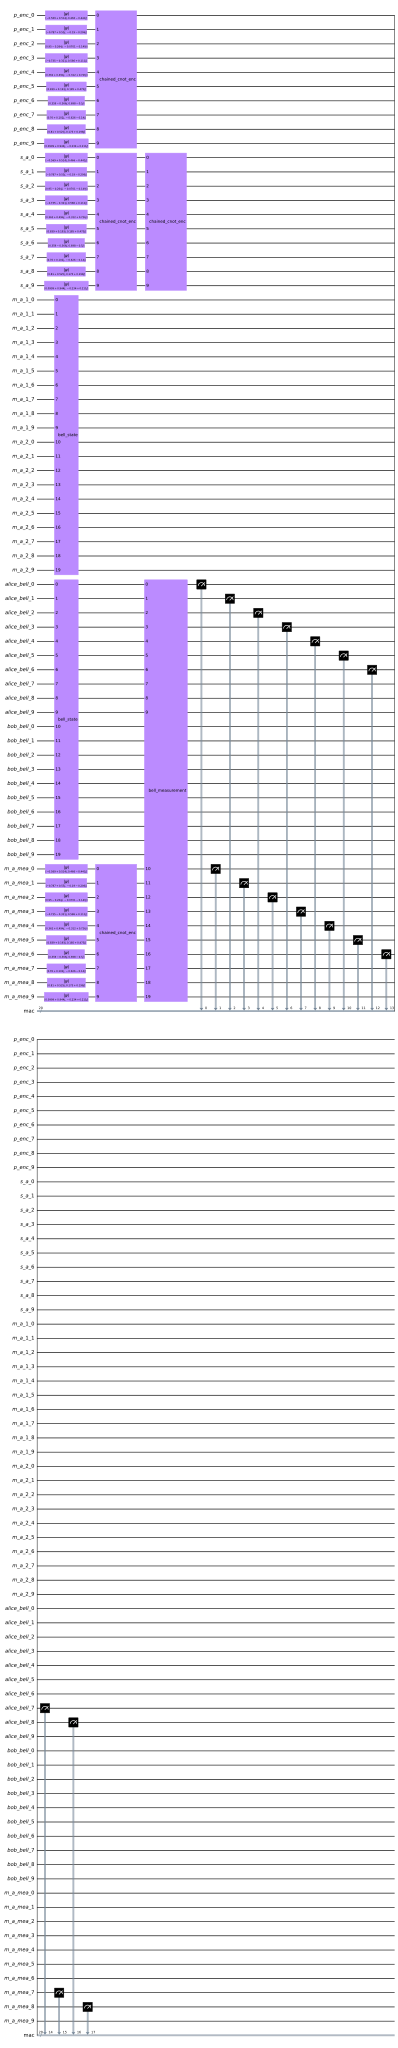

In [54]:
for i in range(n-1):
    qc.measure(A_bell[i], get_M_A[2*i])
    qc.measure(for_M_A[i], get_M_A[2*i+1])
    if get_M_A[2*i] == 1:
        qc.x(for_M_A[i])  #.c_if(2*i, 1)
    if get_M_A[2*i+1] == 1:
        qc.z(A_bell[i])  #.c_if(2*i+1, 1)
    
qc.draw()

In [55]:
qc.draw(output="text")

┌────────────────────────────────────────────────┐»
     p_enc_0: ─┤ Initialize(-0.56904+0.51395j,0.46631-0.44114j) ├»
               ├────────────────────────────────────────────────┤»
     p_enc_1: ─┤ Initialize(-0.78678+0.55009j,-0.18992-0.2057j) ├»
              ┌┴────────────────────────────────────────────────┤»
     p_enc_2: ┤ Initialize(0.95027-0.26425j,-0.070144-0.14913j) ├»
              └┬────────────────────────────────────────────────┤»
     p_enc_3: ─┤ Initialize(-0.73536-0.32138j,0.58623+0.11088j) ├»
               └┬──────────────────────────────────────────────┬┘»
     p_enc_4: ──┤ Initialize(0.3615+0.4943j,-0.31248+0.72618j) ├─»
               ┌┴──────────────────────────────────────────────┤ »
     p_enc_5: ─┤ Initialize(0.83941+0.19311j,0.18477+0.47324j) ├─»
               ├───────────────────────────────────────────────┤ »
     p_enc_6: ─┤ Initialize(0.35873-0.36638j,0.69764-0.50039j) ├─»
               └┬──────────────────────────────────────────────┤ »
     p_enc_7: ──┤ Initialize(0.75991+0.1022j,-0.6265-0.13997j) ├─»
                ├─────────────────────────────────────────────┬┘ »
     p_enc_8: ──┤ Initialize(0.8096+0.52515j,0.17252+0.1975j) ├──»
              ┌─┴─────────────────────────────────────────────┴─┐»
     p_enc_9: ┤ Initialize(0.099936+0.94378j,-0.23371+0.21138j) ├»
              └┬────────────────────────────────────────────────┤»
       s_a_0: ─┤ Initialize(-0.56904+0.51395j,0.46631-0.44114j) ├»
               ├────────────────────────────────────────────────┤»
       s_a_1: ─┤ Initialize(-0.78678+0.55009j,-0.18992-0.2057j) ├»
              ┌┴────────────────────────────────────────────────┤»
       s_a_2: ┤ Initialize(0.95027-0.26425j,-0.070144-0.14913j) ├»
              └┬────────────────────────────────────────────────┤»
       s_a_3: ─┤ Initialize(-0.73536-0.32138j,0.58623+0.11088j) ├»
               └┬──────────────────────────────────────────────┬┘»
       s_a_4: ──┤ Initialize(0.3615+0.4943j,-0.31248+0.72618j) ├─»
               ┌┴──────────────────────────────────────────────┤ »
       s_a_5: ─┤ Initialize(0.83941+0.19311j,0.18477+0.47324j) ├─»
               ├───────────────────────────────────────────────┤ »
       s_a_6: ─┤ Initialize(0.35873-0.36638j,0.69764-0.50039j) ├─»
               └┬──────────────────────────────────────────────┤ »
       s_a_7: ──┤ Initialize(0.75991+0.1022j,-0.6265-0.13997j) ├─»
                ├─────────────────────────────────────────────┬┘ »
       s_a_8: ──┤ Initialize(0.8096+0.52515j,0.17252+0.1975j) ├──»
              ┌─┴─────────────────────────────────────────────┴─┐»
       s_a_9: ┤ Initialize(0.099936+0.94378j,-0.23371+0.21138j) ├»
              └─────────────────┬──────────────┬────────────────┘»
     m_a_1_0: ──────────────────┤0             ├─────────────────»
                                │              │                 »
     m_a_1_1: ──────────────────┤1             ├─────────────────»
                                │              │                 »
     m_a_1_2: ──────────────────┤2             ├─────────────────»
                                │              │                 »
     m_a_1_3: ──────────────────┤3             ├─────────────────»
                                │              │                 »
     m_a_1_4: ──────────────────┤4             ├─────────────────»
                                │              │                 »
     m_a_1_5: ──────────────────┤5             ├─────────────────»
                                │              │                 »
     m_a_1_6: ──────────────────┤6             ├─────────────────»
                                │              │                 »
     m_a_1_7: ──────────────────┤7             ├─────────────────»
                                │              │                 »
     m_a_1_8: ──────────────────┤8             ├─────────────────»
                                │              │                 »
     m_a_1_9: ──────────────────┤9             ├──────────────